## Анализ и прогнозирование временных рядов методами искусственного интеллекта

### **Практическая работа 7. Востановление пропусков и прогноз значений временного ряда.**


#### **7.1 Аналитечкие методы востановления временного ряда**

##### *Краткое описание*

В данном пункте практической работы вам предстоит познакомиться с базовыми, аналитическими методами восстановления временных рядов.
Для выполнения данного пункта из каждой группы методов, представленных в ***табл. 7.1*** вам необходимо выбрать по одному методу восстановления ряда. При работе с первой группой, вам необходимо самостоятельно реализовать выбранный метод.  

**Табл. 7.1** - Группы аналитических методов восстановления.
№|Название группы|Модели и методы|
--|----|----|
1|Заполнение существующими значениями ряда|Средним, медианной, Hot-Deck|
2|Заполнение на основе близки значений|[Интерполяция](https://scikit-learn.org/stable/auto_examples/linear_model/plot_polynomial_interpolation.html),  [KNNi](https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html)|
3|На основе матричных разложений|[CD-Rec](#Fixme:Дат ссылку), [SVD](https://pypi.org/project/fancyimpute/)|

In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

In [4]:

path_data = Path('datasets')/'madrid.txt'
madrid = np.loadtxt(path_data)[:,0]
print(madrid.shape)

(25000,)


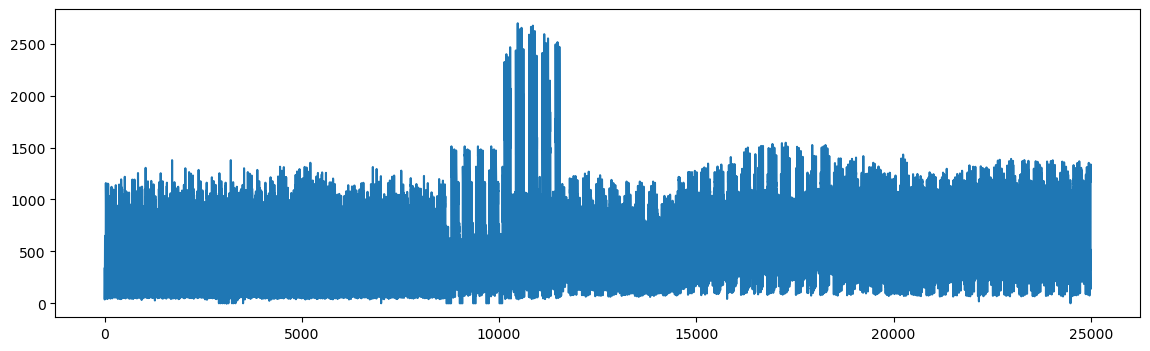

In [5]:
fig, ax =  plt.subplots(figsize=(14,4),ncols=1,nrows=1)
plt.plot(madrid[:])
plt.show()

Самостоятельно реализуйте функцию, принимающую на вход многомерный временной ряд и возвращающий:
1. Все подпоследовательности временного ряда, в которых некоторые значения временного ряда были заменены nan значениями.
2. Индексы пропущенных значейни
   
Процен пппроущенных значений должен регулироваться тедельным параметром.


In [6]:
import copy
import torch
import random

random.seed(0)

In [7]:
def add_nan(x, percent = 0.25):
    x_with_nan = copy.deepcopy(x)
    nan_len = x.shape[0] * percent
    nan_counter = 0
    x_with_nan_index = []

    for i in range(x_with_nan.shape[0]):
        if nan_counter <= nan_len and random.randint(0, 1):
            x_with_nan[i] = np.nan
            nan_counter += 1

    return x_with_nan, np.isnan(x_with_nan)

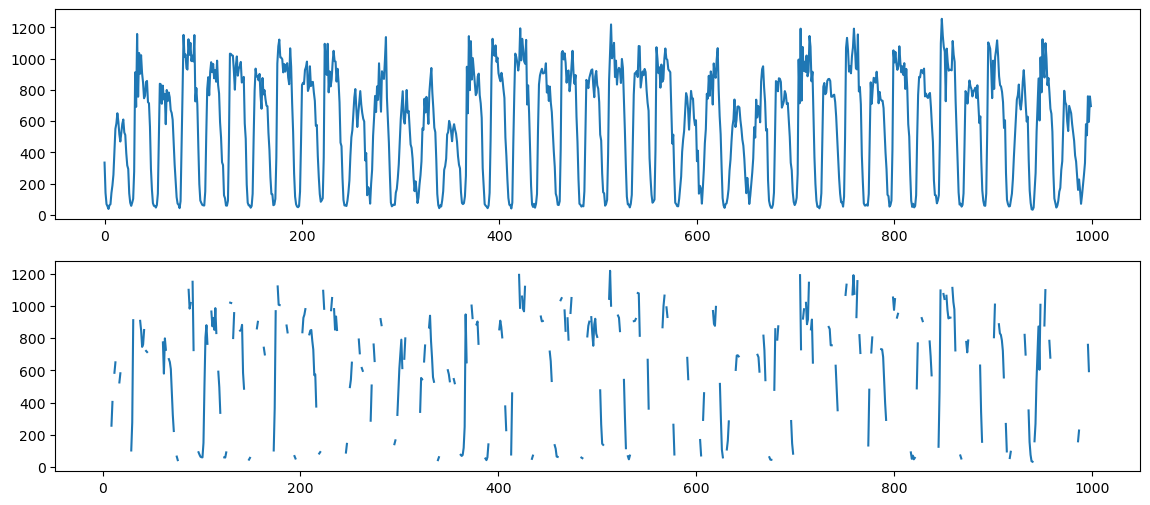

In [8]:
madrid_with_nan, index = add_nan(madrid)
fig, ax =  plt.subplots(figsize=(14,6),ncols=1,nrows=2)
ax[0].plot(madrid[:1000])
ax[1].plot(madrid_with_nan[:1000])
plt.show()

##### 7.1.2 Заполнение существующими значениями ряда


In [9]:
recovery = {}

In [10]:
madrid_mean = madrid_with_nan.copy()
madrid_mean[index] = np.nanmean(madrid_mean)
recovery['mean'] = madrid_mean

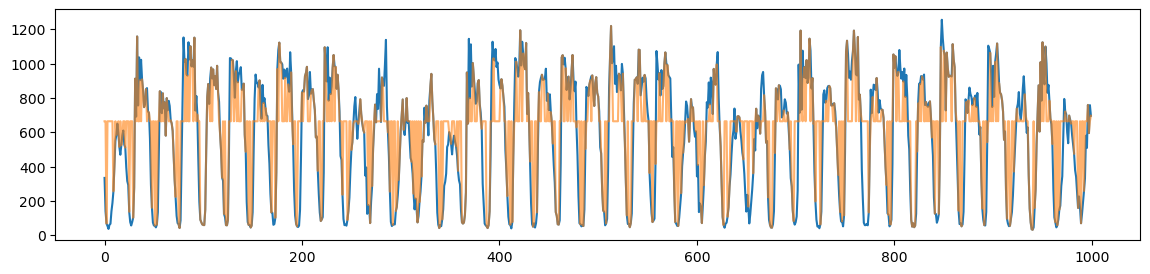

In [11]:
fig, ax =  plt.subplots(figsize=(14,3),ncols=1,nrows=1)
ax.plot(madrid[:1000])
ax.plot(madrid_mean[:1000], alpha=0.6)
plt.show()

In [12]:
madrid_median = madrid_with_nan.copy()
madrid_median[index] = np.nanmedian(madrid_median)

In [13]:
recovery['median'] = madrid_median

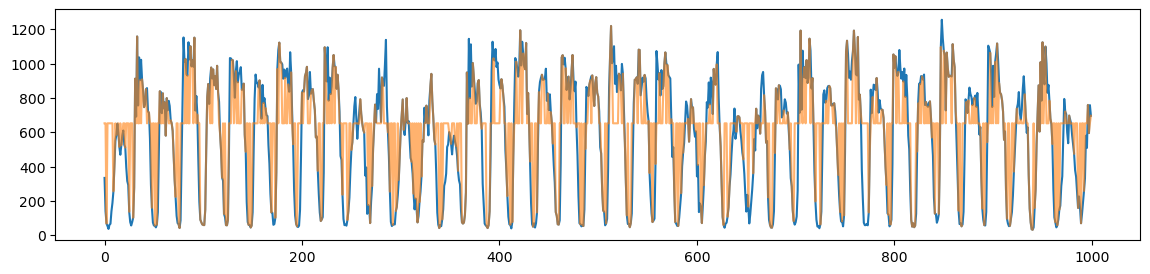

In [14]:
#madrid_with_nan, index = add_nan(madrid)
fig, ax =  plt.subplots(figsize=(14,3),ncols=1,nrows=1)
ax.plot(madrid[:1000])
ax.plot(madrid_median[:1000], alpha=0.6)
plt.show()

Самостоятельно реализуйте один метод из первой группы ***табл. 7
.1*** и проведите востановление данных, сохратив результаты востановления.

In [15]:
madrid_with_nan.shape

(25000,)

In [16]:
madrid_with_nan = madrid_with_nan.reshape(-1, 1)
madrid_with_nan.shape

(25000, 1)

In [17]:
# Hot-Deck

def get_not_nan_row(index, i_indx, x, x_indx, step):

    # index - массив индексов
    # i_indx - индекс строки массива индексов, для заполнения которой ищем значения
    # x - массив значений
    # x_indx - индекс строки массива значений, в которой ищем значения
    # step - шаг

    if x.shape[0] <= x_indx and x_indx >= 0:
        return np.nan

    if ~np.isnan(x[x_indx][index[i_indx]]).all():
        return x[x_indx][index[i_indx]]

    return np.nan


def hot_deck(x, index):
    hot_deck = x.copy()

    for i in range(x.shape[0]):
        if index[i].any():

            for j in range(i, x.shape[0]):
                if ~np.isnan(hot_deck[j][index[i]]).any():
                    next_row = hot_deck[j][index[i]]
                    break

            if ~np.isnan(next_row).any():
                hot_deck[i][index[i]] = next_row
            else:
                for j in range(i, 0, -1):
                    if ~np.isnan(hot_deck[j][index[1]]).any():
                        prev_row = hot_deck[j][index[i]]
                        break

                if ~np.isnan(prev_row).any():
                    hot_deck[i][index[i]] = prev_row

    return hot_deck

In [18]:
madrid_hot_deck = hot_deck(madrid_with_nan, index)

In [19]:
recovery['hot_deck'] = madrid_hot_deck

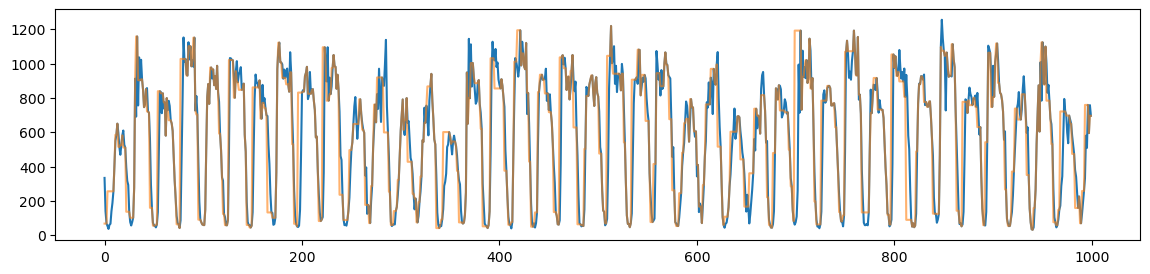

In [20]:
fig, ax =  plt.subplots(figsize=(14,3),ncols=1,nrows=1)
ax.plot(madrid[:1000])
ax.plot(madrid_hot_deck[:1000], alpha=0.6)
plt.show()

##### 7.1.3 Заполнение на основе близких значений


Используя документацию одного из методов востановления второй группы ***табл. .1*** и проведите востановление данных, сохратив результаты востановления.

In [21]:
from sklearn.impute import KNNImputer

In [22]:
madrid_with_nan, index = add_nan(madrid)

In [23]:
def rolling_window(a, window, intersection=False):
    # result = torch.zeros(size=(a.shape[0],a.shape[1]))
    returns = []
    if intersection:
        for i in range(0, a.shape[0]-window):
            returns.append(a[i:i + window])
    else:
        for i in range(0, a.shape[0],window):
            returns.append(a[i:i + window])
    return np.stack(returns)

In [24]:
madrid_slice = rolling_window(madrid_with_nan, 100)

imputer = KNNImputer(n_neighbors=10)

madrid_knn_imputer = imputer.fit_transform(madrid_slice)
madrid_knn_imputer = madrid_knn_imputer.ravel()

In [25]:
recovery['knn_imputer'] = madrid_knn_imputer

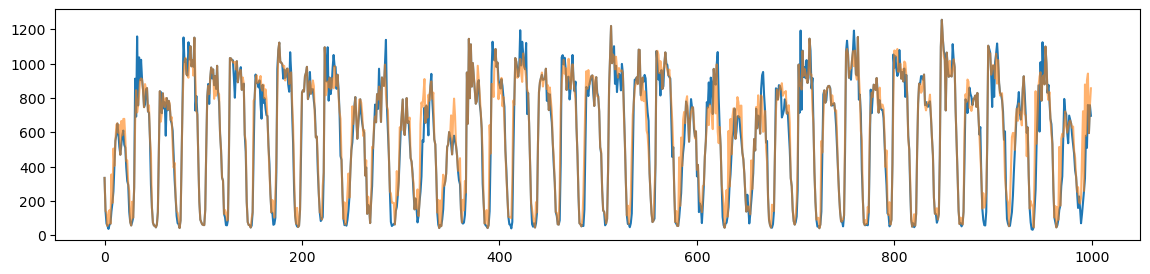

In [26]:
fig, ax =  plt.subplots(figsize=(14,3),ncols=1,nrows=1)
ax.plot(madrid[:1000])
ax.plot(madrid_knn_imputer[:1000], alpha=0.6)
plt.show()

##### 7.1.4 Заполнение на матричных преобразований

Используя документацию одного из методов востановления третей группы ***табл. 7.1*** и проведите востановление данных, сохратив результаты востановления.

In [27]:
!pip install fancyimpute

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Obtaining dependency information for cvxpy from https://files.pythonhosted.org/packages/38/85/5f46779431dd978f62a1f5bd64df05d9a1418cc50d7294e98bf445e31068/cvxpy-1.4.2-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for cvxopt from https://files.pythonhosted.org/packages/a3/52/2237d72cf007e6c36367ab8a776388a9f13511e4cfa8a71b79101ad6e0fa/cvxopt-1.3.2-cp311-cp311-win_amd64.whl.metadata
     ---------------------------------------- 0.0/154.7 kB ? eta -:--:--
     --------- --------------------------- 41.0/154.7 kB 991.0 kB/s eta 0:00:01
     ----------------- ------------------- 71.7/154.7 kB 787.7 kB/s eta 0:00:01
     ----------------------------------- -- 143.4/154.7 kB 1.2 MB/s eta 0:00:01
     -------------------------------------- 154.7/154.7 kB 1.0 MB/s eta 0

In [28]:
from fancyimpute import IterativeSVD

In [29]:
solver = IterativeSVD(rank=2)
madrid_iterative_svd = madrid_slice.copy()
madrid_iterative_svd = solver.fit_transform(madrid_iterative_svd)
madrid_iterative_svd = madrid_iterative_svd.ravel()

[IterativeSVD] Iter 1: observed MAE=344.441842
[IterativeSVD] Iter 2: observed MAE=269.253047
[IterativeSVD] Iter 3: observed MAE=259.911909
[IterativeSVD] Iter 4: observed MAE=257.368365
[IterativeSVD] Iter 5: observed MAE=256.563359
[IterativeSVD] Iter 6: observed MAE=256.298071
[IterativeSVD] Iter 7: observed MAE=256.201140
[IterativeSVD] Iter 8: observed MAE=256.165482
[IterativeSVD] Iter 9: observed MAE=256.151770
[IterativeSVD] Iter 10: observed MAE=256.146407
[IterativeSVD] Iter 11: observed MAE=256.144139


In [30]:
recovery['iterative_svd'] = madrid_iterative_svd

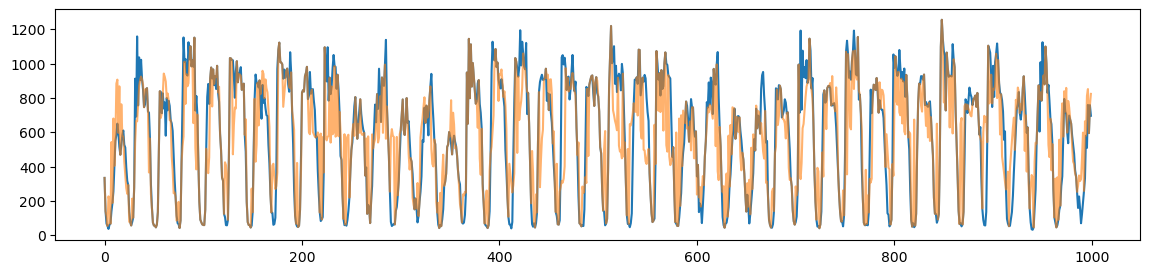

In [31]:
fig, ax =  plt.subplots(figsize=(14,3),ncols=1,nrows=1)
ax.plot(madrid[:1000])
ax.plot(madrid_iterative_svd[:1000], alpha=0.6)
plt.show()

##### 7.1.5 Сравнение результатов востановление.


Используя следующие библиотеки(список библиотек) отдельно для каждой группы методов постройте методов основные метрики оценки качества постановления.
На основе метрик отберите лучшие методы постановления метрик и выберите лучшую группу методов. Для лучших методов из каждой группы постройте графики сравнения реальных и восстановленных данных. Объясните результаты и сделайте вывод.



In [32]:
from sklearn.metrics import mean_squared_error

In [33]:
metrics = {}

for method in recovery:
    metrics[method] = mean_squared_error(madrid, recovery[method])

metrics

{'mean': 44645.35770742836,
 'median': 44263.44668,
 'hot_deck': 23214.8272,
 'knn_imputer': 12661.4939212,
 'iterative_svd': 30432.439852753952}